# Random ODE Generator

## Setting Problem Up

In [596]:
### Imports ###
import numpy as np
from sympy import *
import sympy
import random as rand
import random
import IPython.display as disp
init_printing()
import matplotlib.pyplot as plt

In [597]:
### Setting predetermined values ###

# Setting the order of the equation (fixed)
n = 3

########

# Number of y-type terms (x, y, y', etc.)
T = n + 2

# Minimum number of subterms total (total number of terms in the final equation)
min_subterms = 2

# Maximum number of subterms total (total number of terms in the final equation)
max_subterms = 3

# Maximum number of times a function recursively called to create a function
max_fun = 2

# Sets the cumulative probabilities for the following function types:
# (1) No change (2) power (3) exponential (4) logarithmic (5) trig (6) hyperbolic
function_cdf = [0.1, 0.5, 0.62, 0.74, 1, 1]

# Sets the probability that the function creating function will recursively call
# itself again
recurs_prob = 0.1

# The probability of adding a constant to the function
add_c_prob = 0.5

In [598]:
### Defining the symbols, functions, and terms ###

# Define symbol and function variables
x = Symbol('x')

# Stores the y-type terms (x, y, y', etc.) in an array called y_terms
y_terms = np.empty(T, dtype=Symbol)
y_terms[0] = x

for i in range(1, T):
    #y_terms[i] = y(x).diff(x, i - 1)
    y_terms[i] = Symbol('y'+str(i-1))
    
y_terms

array([x, y0, y1, y2, y3], dtype=object)

## Functions

In [599]:
def num_subterms (sum_min, sum_max):
    '''
    This creates an array of the number of subterms for each y-type term.
    If the number of subterms is less than the specified minimum or greater than
    the specified maximum, the function will call itself recursively until
    a valid number of subterms are determined.

    Parameters
    ----------
    sum_min:  int
              The minimum number of total subterms
    sum_max:  int
              The maximum number of total subterms

    Returns
    ----------
    temp: numpy array of int
          Returns the number of subterms for each y-type term
    '''

    temp = np.empty(T, dtype=int)
    # Initially set that the nth derivative term has one subterm
    temp[-1] = 1

    # Set number of subterms (0, 1, or 2) for remaining terms
    for i in range(T - 1):
        # Sets the probability of having 0 subterms or 1 subterm
        probabilities = [0] * 1 + [1] * 2
        temp[i] = rand.choice(probabilities)

    if (sum(temp) < sum_min or sum_min > sum_max):
        return num_subterms (sum_min, sum_max)
    # return temp
    return [1, 1, 1, 1, 1] # changed this so every order is present in the final ODE

In [600]:
def add_coeff_and_constant(subterm, const_prob = 0.5):
    # Determines coefficient
    coeffs = np.linspace(-5,-1,11, dtype=int)
    if rand.random() < 0.5:
        subterm *= rand.choice(coeffs)
    # elif rand.random() > 0.8:
    #     subterm /= rand.choice(coeffs)

    # Determines added constant
    if rand.random() < const_prob:
        subterm += rand.choice(coeffs)

    return subterm

In [601]:
def generate_random_sympy_polynomial():
    """
    Generates a simple sympy polynomial of x with two or three terms and a maximum power of 4.
    Coefficients range from -5 to 5.

    Returns:
        sympy.Expr: A sympy expression representing the polynomial.
    """

    x = symbols('x')
    num_terms = random.choice([2, 3])
    polynomial = 0

    for _ in range(num_terms):
        coeff = random.choice([i for i in range(-5, 6) if i != 0])
        power = random.randint(0, 4)
        polynomial += coeff * x**power

    return add_coeff_and_constant(polynomial, 1)

# Generate and display a sympy polynomial
random_sympy_polynomial = generate_random_sympy_polynomial()
random_sympy_polynomial

In [602]:
def polynomial_from_coefficients(coefficients, special_func_prob=0.5, power_prob=0.5):
    """
    Converts a list of coefficients into a polynomial expression using sympy.
    Optionally adds a special function to the polynomial.

    Parameters:
    coefficients (list): A list of coefficients, where the index represents the power of x.
    special_func_prob (float): Probability of adding a special function to the polynomial.
    power_prob (float): Probability of raising the special function to a positive power.

    Returns:
    sympy expression: The polynomial expression.
    """
    x = symbols('x')
    polynomial = sum(coef * x**i for i, coef in enumerate(coefficients[::-1]))

    # Check if a special function should be added
    if random.random() < special_func_prob:
        # List of special functions
        special_funcs = [sin(x), cos(x), log(x+1), exp(x)]
        # Choose one special function randomly
        special_func = random.choice(special_funcs)

        # Optionally raise the special function to a positive power
        if random.random() < power_prob:
            power = random.randint(1, 4)  # positive power between 1 and 4
            special_func = special_func**power

        # Add the special function to the polynomial
        polynomial += special_func

    return Poly(polynomial)

In [603]:
def create_subterm (y_term, cdf, iteration, max_it, const_prob):
    '''
    This returns a random subterm (a random function of the given y_term).
    It may recursively call itself to make a more complicated funciton up to
    max_it times.

    The drawable functions include power, exponential, logarithmic,
    trigonometric, and hyperbolic.

    Parameters
    ----------
    y_term:     Object
                The y-type term (x, y, y', etc.)
    cdf:        int
                The cumulative pobability of each function type (power,
                exponential, logarithmic, trigonometric, and hyperbolic)
    iteration:  int
                The iteration number (how many times the function has
                been called)
    max_it:     int
                The maximum number of times the function can be called
    const_prob: float
                The probability of adding a constant to the current subterm

    Returns
    ----------
    subterm:  Object
              Returns a subterm for a function of a given y_term
    '''

    # Default value (function does nothing)
    subterm = y_term

    # RETURNING y3 alone
    if y_term == y_terms[4]:
        return y_terms[4]

    # Randomly determines if a function must be applied (and which function)
    temp = rand.random()
    
    # New Feature: Raise y, y', or y'' to a positive power
    if y_term == y_terms[2]:
        power = rand.randint(2, 5)  # positive power between 1 and 4
        subterm = y_term ** power
        return simplify(subterm)
        
    if y_term in [y_terms[1], y_terms[3]]:
        polynomial = generate_random_sympy_polynomial()
        print(polynomial)
        subterm = 1 / polynomial * y_term
        return simplify(subterm)

    if y_term == y_terms[0]:
        # Trig
        if temp > 0.5:
            # trig_fun = [sin(y_term)] + [cos(y_term)] + [tan(y_term)]
            trig_fun = [sin(y_term)] + [cos(y_term)]
            polynomial = generate_random_sympy_polynomial()
            print(polynomial)
            subterm = 1/(polynomial + rand.choice(trig_fun))
            # subterm = add_coeff_and_constant(subterm, const_prob)
            return simplify(subterm)
        # Exponential
        else:
            subterm = 1/exp(y_term)
            subterm = add_coeff_and_constant(subterm, const_prob)
            return simplify(subterm)
        # f(x)
        # elif temp > cdf[0]:
        #     coefficients = generate_polynomial(degree=4, num_terms=2,coeff_lower_bound=-3,coeff_upper_bound=3)
        #     subterm = 1 / polynomial_from_coefficients(coefficients) * y_term


    if subterm == 0:
        return create_subterm(y_term, cdf, iteration, max_it, const_prob)

    # Will consider reiterating if we have not yet reached the maximum
    # number of iterations

    # if iteration < max_it:
    #     # If so, will add another function on top of this one
    #     if rand.random() < recurs_prob:
    #         # Recursively calls its own function to
    #         # create a more complicated function
    #         subterm = create_subterm(subterm, cdf, iteration + 1, max_it, const_prob)
    #     # If not, will randomly determine if some additional p(x) should be added
    #     elif rand.random() < 2/3:
    #         # Only p(x)
    #         subterm *= create_subterm(x, cdf, max_it, max_it, const_prob)

    return simplify(subterm)

In [604]:
def create_subterms (y_term, num_sub):
    # print(y_term)
    '''
    This returns all subterms of the equation.

    Parameters
    ----------
    y_term:   numpy array of Object
              The y-type terms (x, y, y', etc.)
    num_sub:  numpy array of int
              The number of subterms for each y-type term

    Returns
    ----------
    subterms: numpy array of Object
              Returns all of the subterms for the equation
    '''

    # Stores the subterms
    subterms = np.empty(sum(num_sub), dtype=Mul)

    # Keeps track of index of subterms we are at
    counter = 0

    for i, y_t in enumerate(y_term):
        # print(num_sub[i])
        for n_s in range(num_sub[i]):
            # Determines function to be applied to the y_term
            subterms[counter] = create_subterm(y_t, function_cdf, 1, max_fun, add_c_prob)
            counter += 1

    return subterms

## Final Calculation and Output

In [605]:
terms = create_subterms(y_terms, num_subterms(min_subterms, max_subterms))
print("The terms are:")
for i in range(len(terms)):
    disp.display(terms[i])

-20*x**4 - 40*x**2 - 2
-5*x**4 - 15
The terms are:


In [606]:
y3 = y_terms[4]
new_terms = terms.tolist()
new_terms.remove(y3)
new_terms

In [607]:
y3 = -sum(new_terms)

In [608]:
y3

25*x**4 - 20*x**2 - 10*x - 2
-4*x**3 - 4*x**2 + 3*x - 3
-9*x**3 - 6*x**2 - 4


"- \\frac{y}{4 x^{3} + 4 x^{2} - 3 x + 3} + y'^{2} - \\frac{y''}{9 x^{3} + 6 x^{2} + 4} + \\frac{1}{25 x^{4} - 20 x^{2} - 10 x + \\cos{\\left(x \\right)} - 2}"


\text{Approximate the solution to the third-order ODE: } y''' = - \frac{y}{4 x^{3} + 4 x^{2} - 3 x + 3} + y'^{2} - \frac{y''}{9 x^{3} + 6 x^{2} + 4} + \frac{1}{25 x^{4} - 20 x^{2} - 10 x + \cos{\left(x \right)} - 2}

\text{With initial conditions at } x = 0:
\begin{align*}
y(0) &= 1.00 \\
y'(0) &= 0.00 \\
y''(0) &= 0.00
\end{align*}

y0/(4*x**3 + 4*x**2 - 3*x + 3) - y1**2 + y2/(9*x**3 + 6*x**2 + 4) - 1/(25*x**4 - 20*x**2 - 10*x + cos(x) - 2)


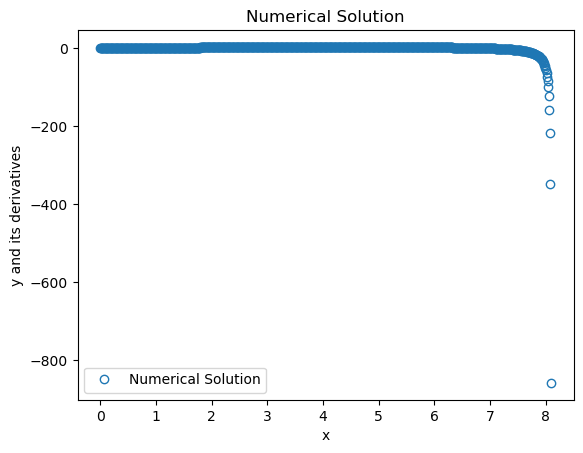

In [609]:
from sympy import symbols, diff, exp
from scipy.integrate import solve_ivp

x = symbols('x')
y, y0, y1, y2, y3 = symbols('y y0 y1 y2 y3')

from sympy.utilities.lambdify import lambdify

terms = create_subterms(y_terms, num_subterms(min_subterms, max_subterms))

# Define the mapping for replacement
replacement_mapping = {
    y0: y,
    y1: symbols("y'"),
    y2: symbols("y''"),
    y3: 0
}

# Function to replace y0, y1, y2 with y, y', y''
def replace_with_differential(expr):
    return expr.subs(replacement_mapping)

replaced_expr = replace_with_differential(sum(terms))

# Converting the replaced expression to LaTeX
latex_replaced_expr = latex(replaced_expr)

display(latex_replaced_expr)

# Extracting the values a, b, c from init_condition
a, b, c = [1,0,0]

# Preparing the updated LaTeX formatted equation with x_0 as 0 and the new form of the equation
updated_latex_equation = f"""
\\text{{Approximate the solution to the third-order ODE: }} y''' = {latex_replaced_expr}

\\text{{With initial conditions at }} x = 0:
\\begin{{align*}}
y(0) &= {a:.2f} \\\\
y'(0) &= {b:.2f} \\\\
y''(0) &= {c:.2f}
\\end{{align*}}
"""

print(updated_latex_equation)

y3 = y_terms[4]
new_terms = terms.tolist()
new_terms.remove(y3)
y3 = -sum(new_terms)

print(y3)

# Lambdify the y3 expression so it can be used as a function
y3_func = lambdify((x, y0, y1, y2), y3)

# Define the system of first-order ODEs using y3 directly
def system_of_odes_with_y3(x, y):
    y0, y1, y2 = y
    # Use y3 as a function
    dy2_dx = y3_func(x, y0, y1, y2)
    return [y1, y2, dy2_dx]

initial_conditions = [1, 0, 0]  # placeholder initial conditions
x_range = (0, 100)
X = np.linspace(x_range[0], x_range[1], 10000)

# Solve the system of ODEs
solution_with_y3 = solve_ivp(system_of_odes_with_y3, x_range, initial_conditions, t_eval=X)

plt.plot(solution_with_y3.t, solution_with_y3.y[0], 'o', mfc='none', label='Numerical Solution')
# plt.plot(solution_with_y3.t, solution_with_y3.y[1], label="y'(x)")
# plt.plot(solution_with_y3.t, solution_with_y3.y[2], label="y''(x)")
plt.legend()
plt.xlabel('x')
plt.ylabel('y and its derivatives')
plt.title('Numerical Solution')
plt.show()

In [610]:
def find_divergence_x_value(solution, component_index=0, threshold=1e3):
    y_values = solution.y[component_index]
    for i, y in enumerate(y_values):
        if abs(y) > threshold:
            return solution.t[i], i
    return None, None  # Return None if the solution does not diverge within the given range

# Example usage:
div_point, index = find_divergence_x_value(solution_with_y3, component_index=0)
if div_point is not None:
    print(f"The solution diverges at x = {div_point}")
else:
    print("The solution does not diverge within the given range")


The solution does not diverge within the given range


In [611]:
def find_divergence_x_value(solution, component_index=0, threshold=1e3):
    y_values = solution.y[-1]
    return solution.t[-1], y_values  # Return None if the solution does not diverge within the given range

# Example usage:
div_point, index = find_divergence_x_value(solution_with_y3, component_index=0)
if div_point is not None:
    print(f"The solution diverges at x = {div_point}")
else:
    print("The solution does not diverge within the given range")

The solution diverges at x = 8.090809080908091


**Plotting the dominant balances**

In [612]:
terms = -terms
terms

array([-1/(25*x**4 - 20*x**2 - 10*x + cos(x) - 2),
       y0/(4*x**3 + 4*x**2 - 3*x + 3), -y1**2, y2/(9*x**3 + 6*x**2 + 4),
       -y3], dtype=object)

In [613]:
# Define the symbols used in the expressions
x, y0, y1, y2 = symbols('x y0 y1 y2')

new_terms = terms[:4]
print(new_terms)

# Convert each expression to a function
term_funcs = [lambdify((x, y0, y1, y2), new_term) for new_term in new_terms]

# Assuming solution_with_y3 is your solution object from solve_ivp
x_values = solution_with_y3.t
y_values0 = solution_with_y3.y[0]
y_values1 = solution_with_y3.y[1]
y_values2 = solution_with_y3.y[2]

# Evaluate each function with the numerical solutions
evaluated_terms = [func(x_values, y_values0, y_values1, y_values2) for func in term_funcs]

# y_values3 is calculated as the sum of all the other evaluated terms
y_values3 = sum(evaluated_terms)

# Now you can access each term
term1, term2, term3, term4 = evaluated_terms
list_of_terms = [term1, term2, term3, term4]
term5 = y_values3

[-1/(25*x**4 - 20*x**2 - 10*x + cos(x) - 2) y0/(4*x**3 + 4*x**2 - 3*x + 3)
 -y1**2 y2/(9*x**3 + 6*x**2 + 4)]


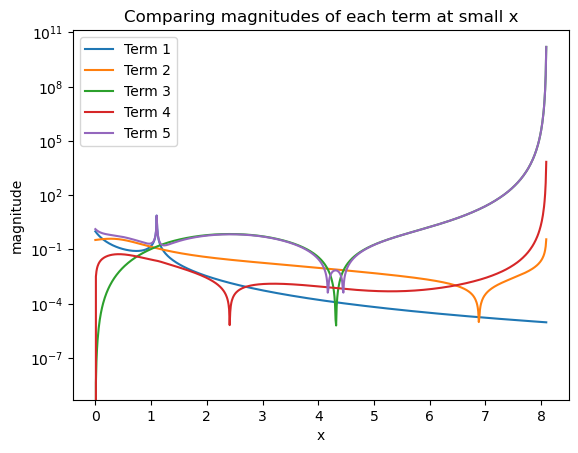

In [614]:
for i in range(len(list_of_terms)):
    plt.plot(solution_with_y3.t, abs(list_of_terms[i]), label = f"Term {i+1}");

plt.plot(solution_with_y3.t, abs(term5), label = "Term 5");
plt.xlabel('x')
plt.ylabel('magnitude')
# plt.xlim([0,3])
plt.yscale("log")
plt.title("Comparing magnitudes of each term at small x")
plt.legend();

In [615]:
div_point

## Approximate Formula for Divergent Solution

### Find the two largest terms at the divergence point

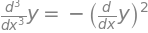

In [616]:
# Define the symbolic variable y and x
y, x = symbols('y x')

# Function to translate terms into differential forms
def translate_to_differential(expr):
    return expr.subs({y0: y, y1: Derivative(y, x), y2: Derivative(y, x, x)})

# Steps to find index of the largest term at the last x-value
last_x_value = solution_with_y3.t[-1]
evaluated_at_last_x = [abs(term[-1]) for term in list_of_terms]
terms_with_index = [(i, value) for i, value in enumerate(evaluated_at_last_x)]
terms_with_index.sort(key=lambda x: x[1], reverse=True)
largest_terms_indices = [terms_with_index[0][0]]

# Translate the largest term into its differential form
largest_term_index = largest_terms_indices[0]
largest_term_expression = new_terms[largest_term_index] if largest_term_index < len(new_terms) else None

largest_term_differential = translate_to_differential(largest_term_expression) \
if largest_term_expression is not None else None

# Define an equation where the third derivative of y is equal to the largest term's differential
y_triple_prime_equation = Eq(Derivative(y, x, x, x), largest_term_differential)

y_triple_prime_equation

### Plug in the Ansatz to Obtain Approximation

In [617]:
# Define the symbols
alpha, p = symbols('alpha p')
x = symbols('x')

# Define the expressions for the derivatives of y based on your solution guess
y_prime_expr = alpha * p * (x - div_point)**(p - 1)
y_double_prime_expr = alpha * p * (p - 1) * (x - div_point)**(p - 2)
y_triple_prime_expr = alpha * p * (p - 1) * (p - 2) * (x - div_point)**(p - 3)

# Assuming y_triple_prime_equation is already defined and includes terms with y', y'', and y'''
# Substitute these expressions into the equation
equation_with_derivatives = y_triple_prime_equation.subs({
    Derivative(y, x): y_prime_expr,
    Derivative(y, x, x): y_double_prime_expr,
    Derivative(y, x, x, x): y_triple_prime_expr
})

equation_with_derivatives

### Find $\alpha$ and $p$

In [618]:
from sympy import symbols, Eq, solve, collect

# Collect terms with respect to (x - div_point) on both sides to isolate coefficients and powers
lhs_collected = collect(equation_with_derivatives.lhs, (x - div_point))
rhs_collected = collect(equation_with_derivatives.rhs, (x - div_point))

# Extract the coefficients and powers
# This assumes the equation is simplified to a single term on each side
coeffs1, power1 = lhs_collected.as_coeff_exponent((x - div_point))
coeffs2, power2 = rhs_collected.as_coeff_exponent((x - div_point))

# Set up the equations
coeff_eq = Eq(coeffs1, coeffs2)
power_eq = Eq(power1, power2)

# print(coeff_eq)

# Solve the system of equations
solution = solve((coeff_eq, power_eq), (alpha, p))

for sol in solution:
    alpha_val, p_val = sol
    if alpha_val != 0 and p_val != 0:
        nonzero_solution = sol
        break

if nonzero_solution:
    alpha_val, p_val = nonzero_solution
    # alpha_val = N(alpha_val)
    print(f"Nonzero solution found: alpha = {alpha_val}, p = {p_val}")
else:
    print("No nonzero solution found.")

Nonzero solution found: alpha = 6, p = -1


### Find C

In [619]:
x_value = solution_with_y3.t[-100]
y_value = solution_with_y3.y[0, -100]

# Define the symbols
x, C = symbols('x C')

# The formula
y_formula = alpha_val * -(div_point-x)**p_val + C

# Create an equation by substituting x_value and y_value
equation_for_C = Eq(y_value, y_formula.subs(x, x_value))

# print(equation_for_C)

# Solve for C
C_value = solve(equation_for_C, C)

# Assuming there's a unique solution for C
if C_value:
    C_solution = C_value[0]
    print(f"Value of C: {C_solution}")
else:
    print("No solution found for C.")

Value of C: 4.98627316229289


### Plot

In [620]:
# Define the approximate solution function
def analyticalapproximation(x):
    return np.sign((x-div_point)) * alpha_val * (np.abs((x-div_point))) ** p_val + C_solution

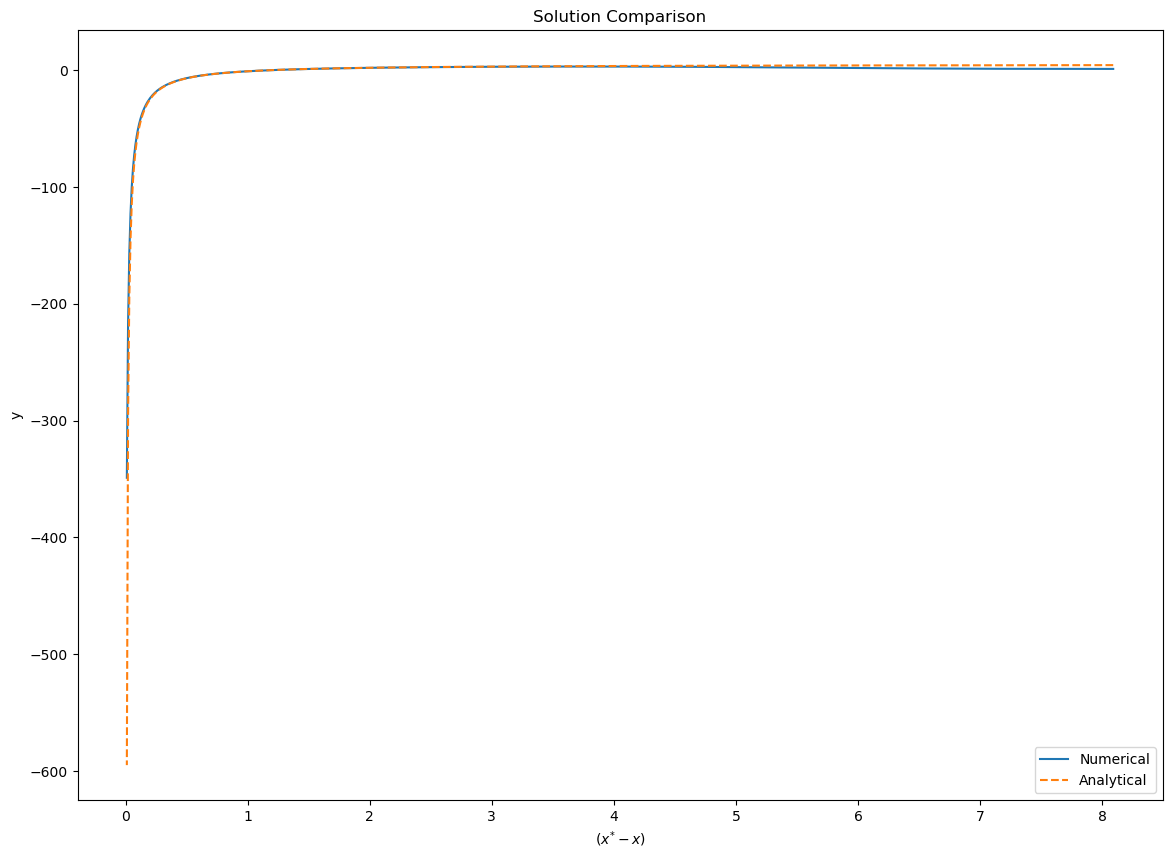

In [621]:
# Remove the last element from solution_with_y3.t
modified_t_values = solution_with_y3.t[:-1]

# Calculate the analytical approximation using the modified t values
Yana = analyticalapproximation(modified_t_values)

# Plotting
plt.figure(figsize=[14, 10])
plt.plot((div_point - modified_t_values), solution_with_y3.y[0, :-1], '-', label='Numerical')
plt.plot((div_point - modified_t_values), Yana, '--', label='Analytical')
plt.title("Solution Comparison")
# plt.xlim([1e-10,1])  # Uncomment if you need to set x-axis limits
plt.xlabel("$(x^{*}-x)$")
plt.ylabel("y")
plt.legend()
plt.show()

For the small x regime, the dominant terms are determined by looking at the point div_point / 4 (arbitrarily chosen, but to prevent it from going into other intermediate regimes) 

In [622]:
solution_with_y3.t.size

In [623]:
index

array([ 0.00000000e+00,  1.28927755e-02,  2.49940059e-02,  3.64126875e-02,
        4.72399563e-02,  5.75554202e-02,  6.74271589e-02,  7.69117242e-02,
        8.60541395e-02,  9.48915220e-02,  1.03461236e-01,  1.11789236e-01,
        1.19898855e-01,  1.27811500e-01,  1.35546656e-01,  1.43121884e-01,
        1.50552824e-01,  1.57853188e-01,  1.65034768e-01,  1.72107433e-01,
        1.79079125e-01,  1.85955866e-01,  1.92742029e-01,  1.99446774e-01,
        2.06075184e-01,  2.12629404e-01,  2.19111412e-01,  2.25523017e-01,
        2.31865858e-01,  2.38141409e-01,  2.44350974e-01,  2.50495687e-01,
        2.56576517e-01,  2.62594262e-01,  2.68549554e-01,  2.74442854e-01,
        2.80274456e-01,  2.86044487e-01,  2.91752904e-01,  2.97399496e-01,
        3.02983884e-01,  3.08505520e-01,  3.13963688e-01,  3.19357505e-01,
        3.24685919e-01,  3.29947707e-01,  3.35141482e-01,  3.40265686e-01,
        3.45318593e-01,  3.50299665e-01,  3.55210888e-01,  3.60051459e-01,
        3.64820494e-01,  

In [624]:
import heapq

**For small x approximation**

It might be better to fix x at something like $x=0.01$ for where to compute the dominant balance at.

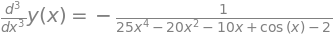

In [640]:
target_x = 0.1

# Find the index of the value closest to target_x
index_closest_small_x = np.argmin(np.abs(solution_with_y3.t - target_x))

# Steps to find index of the largest term at the last x-value
small_x_value = solution_with_y3.t[index_closest_small_x]
evaluated_at_last_x = [abs(term[index_closest_small_x]) for term in list_of_terms]
terms_with_index = [(i, value) for i, value in enumerate(evaluated_at_last_x)]
terms_with_index.sort(key=lambda x: x[1], reverse=True)
largest_terms_indices = [terms_with_index[0][0]]

# Translate the largest term into its differential form
largest_term_index = largest_terms_indices[0]
largest_term_expression = new_terms[largest_term_index] if largest_term_index < len(new_terms) else None

largest_term_differential = translate_to_differential(largest_term_expression) \
if largest_term_expression is not None else None

# Define an equation where the third derivative of y is equal to the largest term's differential
y_triple_prime_equation_small = Eq(Derivative(y, x, x, x), largest_term_differential)

y_triple_prime_equation_small

In [626]:
largest_term_differential = largest_term_differential.subs(x, 0)

In [627]:
largest_term_differential

In [628]:
y = Function('y')(x)


In [629]:
small_x_expression = dsolve(Derivative(y, x, x, x) -  largest_term_differential, y)
small_x_expression

In [630]:
small_x_expression_substituted = small_x_expression.subs({sympy.Symbol('C1'): 1, sympy.Symbol('C2'): 0, sympy.Symbol('C3'): 0})
small_x_expression_substituted

In [631]:
final_eq = lambdify(x, small_x_expression_substituted.rhs)

In [632]:
final_eq

<function _lambdifygenerated(x)>

In [633]:
# Define the approximate solution function
def small_analytical_approximation(x):
    return final_eq(x)

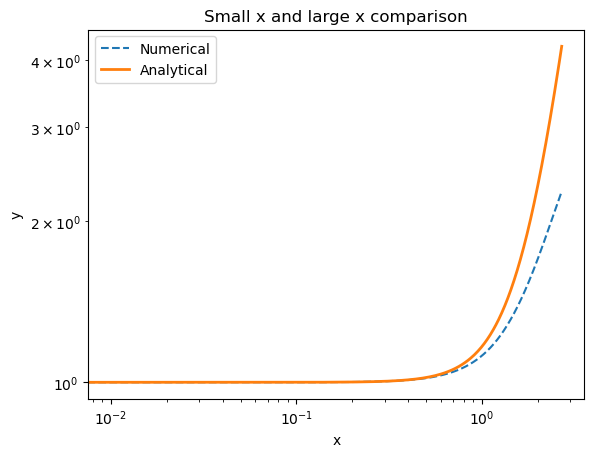

In [634]:
Yana=np.array([[small_analytical_approximation(xi)]for xi in solution_with_y3.t])

one_third_index = len(solution_with_y3.t) // 3

plt.loglog(solution_with_y3.t[:one_third_index], np.abs(solution_with_y3.y[0,:one_third_index]),'--',label = 'Numerical')
plt.loglog(solution_with_y3.t[:one_third_index], np.abs(Yana[:one_third_index]),'-',label = 'Analytical', linewidth=2)
plt.title("Small x and large x comparison")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

**LaTeX problem statement generator**

In [635]:
terms

array([-1/(25*x**4 - 20*x**2 - 10*x + cos(x) - 2),
       y0/(4*x**3 + 4*x**2 - 3*x + 3), -y1**2, y2/(9*x**3 + 6*x**2 + 4),
       -y3], dtype=object)

In [647]:
x = sympy.symbols('x')
y = sympy.Function('y')(x)

derivatives = [y, y.diff(x), y.diff(x, x), y.diff(x, x, x)]

first_term_replaced = terms[0].subs(x, x) # x
second_term_replaced = terms[1].subs(y0, y) # y
third_term_replaced = terms[2].subs(y1, y.diff(x)) # dydx
fourth_term_replaced = terms[3].subs(y2, y.diff(x, x)) # d2ydx2
fifth_term_replaced = terms[4].subs(y3, y.diff(x, x, x)) # d3ydx3

sum_terms = first_term_replaced + second_term_replaced + third_term_replaced + fourth_term_replaced

differential_equation = Eq(fifth_term_replaced, sum_terms)

dollar_sign = "$$"

print("The third-order ODE is given by the following equation: " + "$$" + latex(differential_equation) + "$$")
print("The dominant balance in the small x regime is given by " + "$$" + latex(y_triple_prime_equation_small) + ",$$"
    + " and the dominant balance in the large x regime is given by " + "$$" + latex(y_triple_prime_equation) + "$$")

print("Using the dominant balance in the small x regime, the solution can be derived by \
    setting $x=0$, analytically solving the dominant balance equation \
    for y, and plugging in the initial conditions. The solution is thus " + "$$" + latex(small_x_expression_substituted)
    + "$$" + " in the small x regime.")

print("The solution for the large x regime uses an ansatz of the form " + "$$ y=\\alpha (x-x^*)^p, $$" 
    + " where $x^*$ is the divergence point. Plugging in the ansatz and solving for the terms yields "
    + "$$" + latex(equation_with_derivatives) + "$$")


The third-order ODE is given by the following equation: $$- y_{3} = - \left(\frac{d}{d x} y{\left(x \right)}\right)^{2} - \frac{1}{25 x^{4} - 20 x^{2} - 10 x + \cos{\left(x \right)} - 2} + \frac{y{\left(x \right)}}{4 x^{3} + 4 x^{2} - 3 x + 3} + \frac{\frac{d^{2}}{d x^{2}} y{\left(x \right)}}{9 x^{3} + 6 x^{2} + 4}$$
The dominant balance in the small x regime is given by $$\frac{d^{3}}{d x^{3}} y{\left(x \right)} = - \frac{1}{25 x^{4} - 20 x^{2} - 10 x + \cos{\left(x \right)} - 2}$$, and the dominant balance in the large x regime is given by $$\frac{d^{3}}{d x^{3}} y = - \frac{1}{25 x^{4} - 20 x^{2} - 10 x + \cos{\left(x \right)} - 2}$$
Using the dominant balance in the small x regime, the solution can be derived by     setting $x=0$, analytically solving the dominant balance equation     for y, and plugging in the initial conditions. The solution is thus $$y{\left(x \right)} = \frac{x^{3}}{6} + 1$$ in the small x regime.
The solution for the large x regime uses an ansatz of the form $